In [1]:
import numpy as np
from pathlib import Path
from keras.preprocessing import image

### Preprocessing the data 

In [4]:
p = Path(r"C:\Users\prana\OneDrive\Desktop\ML\dataset2")
dirs = p.glob("*")
label_dic = {"cloudy":0,"rain":1,"shine":2,"sunrise":3}
image_data = []
labels = []
for folder in dirs:
    label = str(folder)
    label = label.split("\\")[-1]
    for img_path in folder.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(50,50))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dic[label])

In [5]:
#convert into numpy array
labels = np.array(labels)
image_data = np.array(image_data,dtype = 'float32')/255.0

In [6]:
#shuffle the data
import random
combined = list(zip(image_data,labels))
random.shuffle(combined)
#unzip
image_data[:],labels[:] = zip(*combined)

### Visualization

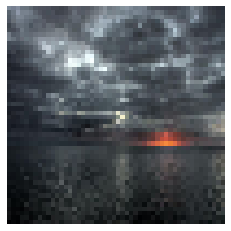

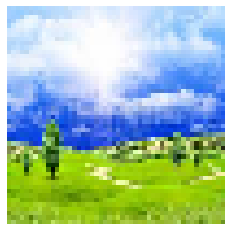

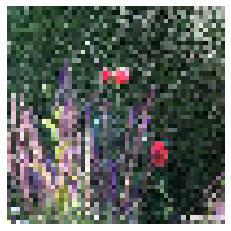

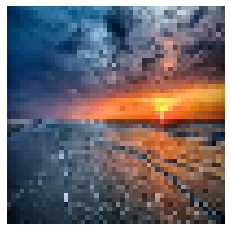

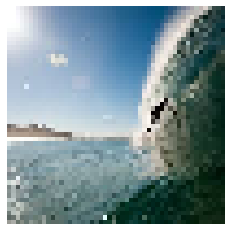

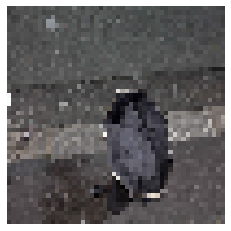

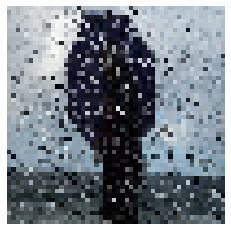

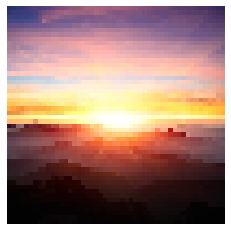

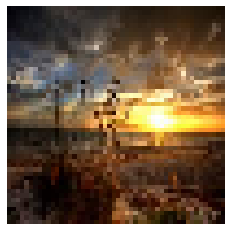

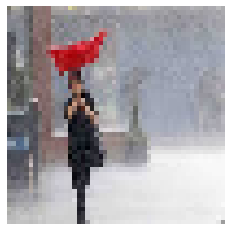

In [7]:
def drawImg(img):
    from matplotlib import pyplot as plt
    
    plt.figure()
    plt.axis("off")
    plt.imshow(img)
    plt.show()

for i in range(10):
    drawImg(image_data[i])

### Building Classifier

In [8]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0.0
        self.b = 0.0
      
    #loss function
    def hingloss(self,W,b,X,Y):
        loss = 0.0
        loss+= 0.5*np.dot(W,W.T)
        m = X.shape[0]
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss+= self.C* max(0,(1-ti))
            
        return loss[0][0]
    
    # Training using Mini batch Gradient descent
    def fit(self,X,Y,learning_rate = 0.001,batch_size =  100,itr =300):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate 
        c = self.C
        W = np.zeros((1,no_of_features))
        bias = 0
        losses = []
        
        for i in range(itr):
            l = self.hingloss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            for batch_start in range(0,no_of_samples,batch_size):
                gradw = 0
                gradb = 0
                for j in range(batch_start,batch_start+batch_size):
                    if(j<no_of_samples):
                        i = ids[j]
                        ti = Y[i]*(np.dot(W,X[i].T)+bias)
                        if(ti>1):
                            gradw += 0
                            gradb+=0
                        else:
                            gradw+=c*Y[i]*X[i]
                            gradb+=c*Y[i]
                            
            
                W = W -n*W + n*gradw
                bias = bias + n*gradb
            
    
        self.W = W
        self.b = bias
        return W,bias,losses

In [9]:
#reshape
m = image_data.shape[0]
image_data = image_data.reshape(m,-1)
classes = len(np.unique(labels))


### Preparing data for One vs One classification

In [10]:
def classWiseData(x,y):
    data = {}
    for i in range(classes):
        data[i] = []
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    #convert data in numpy array
    for k in data.keys():
        data[k] = np.array(data[k])
    
    return data

In [12]:
data = classWiseData(image_data, labels)
data

{0: array([[0.4862745 , 0.53333336, 0.5882353 , ..., 0.0627451 , 0.08627451,
         0.08627451],
        [0.88235295, 0.8980392 , 0.9098039 , ..., 0.38039216, 0.42745098,
         0.09019608],
        [0.52156866, 0.54901963, 0.61960787, ..., 0.34117648, 0.3647059 ,
         0.4117647 ],
        ...,
        [0.14901961, 0.26666668, 0.25882354, ..., 0.34901962, 0.34509805,
         0.3372549 ],
        [0.21176471, 0.21960784, 0.2784314 , ..., 0.09019608, 0.06666667,
         0.07450981],
        [0.4       , 0.4       , 0.39215687, ..., 0.36078432, 0.2784314 ,
         0.10196079]], dtype=float32),
 1: array([[0.22745098, 0.38039216, 0.29803923, ..., 0.39607844, 0.3647059 ,
         0.40784314],
        [0.2627451 , 0.2627451 , 0.2627451 , ..., 0.34901962, 0.3254902 ,
         0.33333334],
        [0.7607843 , 0.78039217, 0.79607844, ..., 0.18431373, 0.23529412,
         0.25882354],
        ...,
        [0.5294118 , 0.49411765, 0.6784314 , ..., 0.29411766, 0.30980393,
         0.21

In [13]:
def getPairdata(d1,d2):
    l1 = d1.shape[0]
    l2 = d2.shape[0]
    samples = l1+l2
    feature = d1.shape[1]
    data_pair = np.zeros((samples,feature))
    data_values = np.zeros((samples,))
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    data_values[:l1] = -1
    data_values[l2:] = +1
    return data_pair,data_values

### Making predictions

In [14]:
mySVM = SVM()

In [15]:
#training nc2 classifiers 
def trainSVMs(x,y):
    svm_classifier = {}
    
    for i in range(classes):
        svm_classifier[i] = {}
        for j in range(i+1,classes):
            xpair,ypair =  getPairdata(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate = 0.00001,itr = 1000)
            svm_classifier[i][j] = (wts,b)
            
    return svm_classifier 


In [16]:
svm_classifier = trainSVMs(image_data,labels)

In [17]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T)+b
    if(z>0):
        return 1
    else:
        return -1
    

In [18]:
def predict(x):
    count = np.zeros((classes,))
    for i in range(classes):
        for j in range(i+1,classes):
            w,b = svm_classifier[i][j]
            z = binaryPredict(x,w,b)
            if z==1:
                count[j] +=1
            else:
                count[i] += 1
    #take the major vote
    final_prediction = np.argmax(count)
    return final_prediction

### Accuracy 

In [19]:
def accuracy(x,y):
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if prediction == y[i]:
            count+=1
            
    
            
    return count/x.shape[0]
      

In [20]:
print(accuracy(image_data,labels))

0.6033868092691622
